In [1]:
import numpy as np
import scipy
import pandas
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('notebook')
import h5py
import allel; print('scikit-allel', allel.__version__)

scikit-allel 1.3.7


In [6]:
#allel.vcf_to_hdf5('./merged.vcf.gz', './keuruu_raw_snps.h5', fields='*')


In [2]:
callset_fn = './keuruu_raw_snps.h5'
callset = h5py.File(callset_fn, mode='r')
callset

<HDF5 file "keuruu_raw_snps.h5" (mode r)>

In [3]:
sorted(callset.keys())

['calldata', 'samples', 'variants']

In [4]:
calldata = callset['calldata']

In [5]:
calldata

<HDF5 group "/calldata" (11 members)>

In [6]:
list(calldata)

['AD', 'DP', 'GQ', 'GT', 'MIN_DP', 'PGT', 'PID', 'PL', 'PS', 'RGQ', 'SB']

In [7]:
variants = allel.VariantChunkedTable(callset['variants'], 
                                     names=['CHROM','POS', 'REF', 'ALT', 'DP', 'QD', 'AN', 'MQ', 'SOR', 'numalt', 'QUAL', 'MQRankSum', 'ReadPosRankSum'])
variants

<VariantChunkedTable shape=(48778104,) dtype=[('CHROM', 'O'), ('POS', '<i4'), ('REF', 'O'), ('ALT', 'O', (3,)), ('DP', '<i4'), ('QD', '<f4'), ('AN', '<i4'), ('MQ', '<f4'), ('SOR', '<f4'), ('numalt', '<i4'), ('QUAL', '<f4'), ('MQRankSum', '<f4'), ('ReadPosRankSum', '<f4')]
   nbytes=3.6G cbytes=1.3G cratio=2.8
   values=h5py._debian_h5py_serial._hl.group.Group>

In [8]:
variants["AN"]

<ChunkedArrayWrapper shape=(48778104,) dtype=int32 chunks=(65536,)
   nbytes=186.1M cbytes=6.2M cratio=30.0
   compression=gzip compression_opts=1
   values=h5py._debian_h5py_serial._hl.dataset.Dataset>

In [9]:
def plot_variant_hist(f, bins=30):
    x = variants[f][:]
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.despine(ax=ax, offset=10)
    ax.hist(x, bins=bins)
    ax.set_xlabel(f)
    ax.set_ylabel('No. variants')
    ax.set_title('Variant %s distribution' % f)

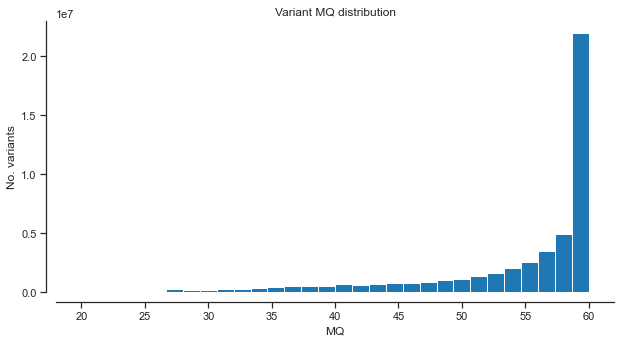

In [10]:
plot_variant_hist('MQ')


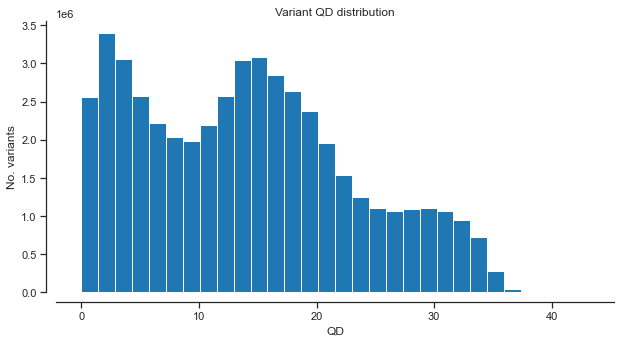

In [11]:
plot_variant_hist('QD')

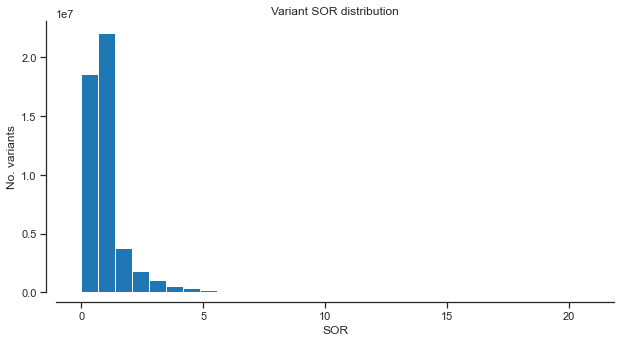

In [12]:
plot_variant_hist('SOR')

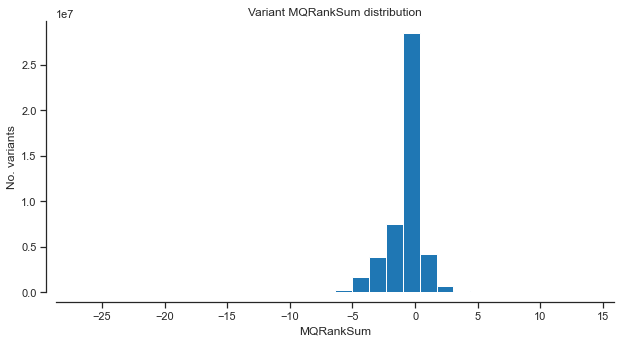

In [13]:
plot_variant_hist('MQRankSum')

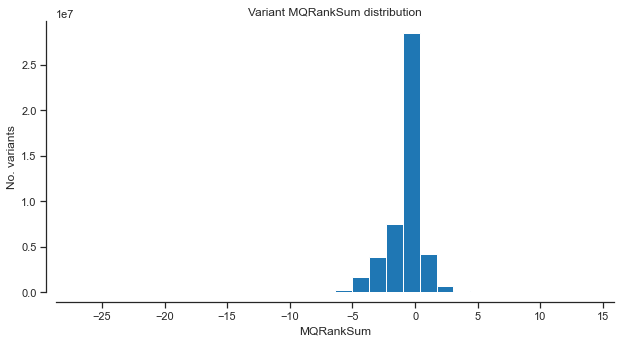

In [14]:
plot_variant_hist('MQRankSum')

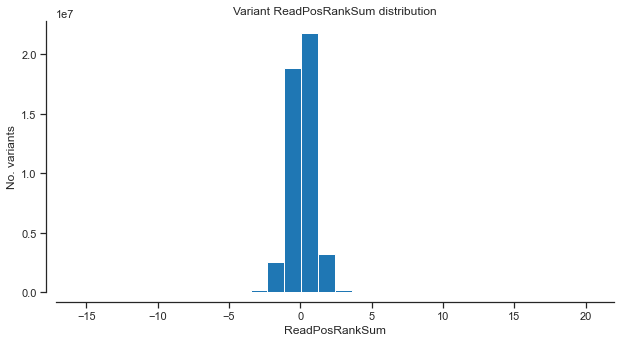

In [15]:
plot_variant_hist('ReadPosRankSum')

In [16]:
filter_expression = '(DP > 20) & (QD > 2) & (AN > 165)'


In [17]:
variant_selection = variants.eval(filter_expression)[:]
variant_selection

array([ True,  True,  True, ...,  True,  True,  True])

In [18]:
np.count_nonzero(variant_selection)

44883893

In [19]:
calldata = callset['calldata']
calldata

<HDF5 group "/calldata" (11 members)>

In [20]:
genotypes = allel.GenotypeChunkedArray(calldata['GT'])
genotypes

<GenotypeChunkedArray shape=(48778104, 165, 2) dtype=int8 chunks=(65536, 64, 2)
   nbytes=15.0G cbytes=1.6G cratio=9.4
   compression=gzip compression_opts=1
   values=h5py._debian_h5py_serial._hl.dataset.Dataset>

In [21]:
samples_fn = './metadata.csv'
samples = pandas.read_csv(samples_fn, sep='\t')
samples

,ID,fam
0,V51346,cross
1,V51347,cross
2,V51348,cross
3,V51349,cross
4,V51350,cross
...,...,...
160,V5920,parent
161,V5923,parent
162,V5930,parent
163,V5934,parent


In [22]:
samples.fam.value_counts()


cross     114
parent     51
Name: fam, dtype: int64

In [23]:
genotypes_subset = genotypes.subset(variant_selection)

In [24]:
genotypes_subset

<GenotypeChunkedArray shape=(44883893, 165, 2) dtype=int8 chunks=(10958, 165, 2)
   nbytes=13.8G cbytes=2.5G cratio=5.5
   compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
   values=zarr.core.Array>

In [25]:
ac = genotypes_subset.count_alleles()
ac

<AlleleCountsChunkedArray shape=(44883893, 7) dtype=int32 chunks=(87664, 7)
   nbytes=1.2G cbytes=183.2M cratio=6.5
   compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
   values=zarr.core.Array>

In [26]:
is_biallelic_01 = ac.is_biallelic_01()[:]
ac1 = ac.compress(is_biallelic_01, axis=0)[:, :2]
ac1

array([[328,   2],
       [329,   1],
       [329,   1],
       ...,
       [328,   2],
       [328,   2],
       [328,   2]], dtype=int32)

<AxesSubplot:xlabel='derived allele frequency', ylabel='site frequency'>

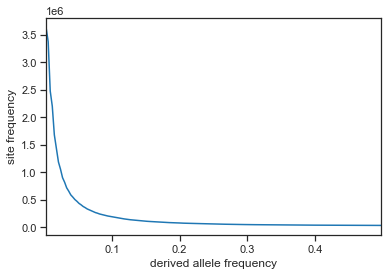

In [27]:
s = allel.sfs_folded(ac1)
allel.plot_sfs(s, yscale="linear", n=ac1.sum(axis=1).max())

In [28]:
biallelic = (ac.max_allele() == 1)
###This is the filter expression for biallelic sites

In [29]:
%%time
genotypes_subset_2 = genotypes_subset.compress(biallelic)
genotypes_subset_2
###subset the array genotypes_subset by keeping only biallelic sites. 

CPU times: user 39.4 s, sys: 1.24 s, total: 40.7 s
Wall time: 13.1 s


<GenotypeChunkedArray shape=(35595409, 165, 2) dtype=int8 chunks=(17381, 165, 2)
   nbytes=10.9G cbytes=1.7G cratio=6.4
   compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
   values=zarr.core.Array>

In [30]:
genotypes_subset_2
###this subset contains the SNPs left after filtering by DP>20, QD>2, and only keeping biallelic sites

<GenotypeChunkedArray shape=(35595409, 165, 2) dtype=int8 chunks=(17381, 165, 2)
   nbytes=10.9G cbytes=1.7G cratio=6.4
   compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
   values=zarr.core.Array>

In [31]:
n_variants = len(genotypes_subset_2)
n_variants

35595409

In [32]:
pc_missing = genotypes_subset_2.count_missing(axis=0)[:] * 100 / n_variants
pc_het = genotypes_subset_2.count_het(axis=0)[:] * 100 / n_variants

In [33]:
samples.fam.unique()
###This identifiers come from the metadata file

array(['cross', 'parent'], dtype=object)

In [34]:
samples


,ID,fam
0,V51346,cross
1,V51347,cross
2,V51348,cross
3,V51349,cross
4,V51350,cross
...,...,...
160,V5920,parent
161,V5923,parent
162,V5930,parent
163,V5934,parent


In [35]:
def plot_genotype_frequency(pc, title):
    fig, ax = plt.subplots(figsize=(24, 5))
    sns.despine(ax=ax, offset=24)
    left = np.arange(len(pc))
    palette = sns.color_palette("hls", 24)
    pop2color = {'parent' : palette[7],
                 'cross': palette[1]}
    colors = [pop2color[p] for p in samples.fam]
    ax.bar(left, pc, color=colors)
    ax.set_xlim(0, len(pc))
    ax.set_xlabel('Sample index')
    ax.set_ylabel('Percent calls')
    ax.set_title(title)
    handles = [mpl.patches.Patch(color=palette[7]),
               mpl.patches.Patch(color=palette[1])]
        
    ax.legend(handles=handles, labels=['parent', 'cross'], title='Family',
              bbox_to_anchor=(1, 1), loc='upper left')

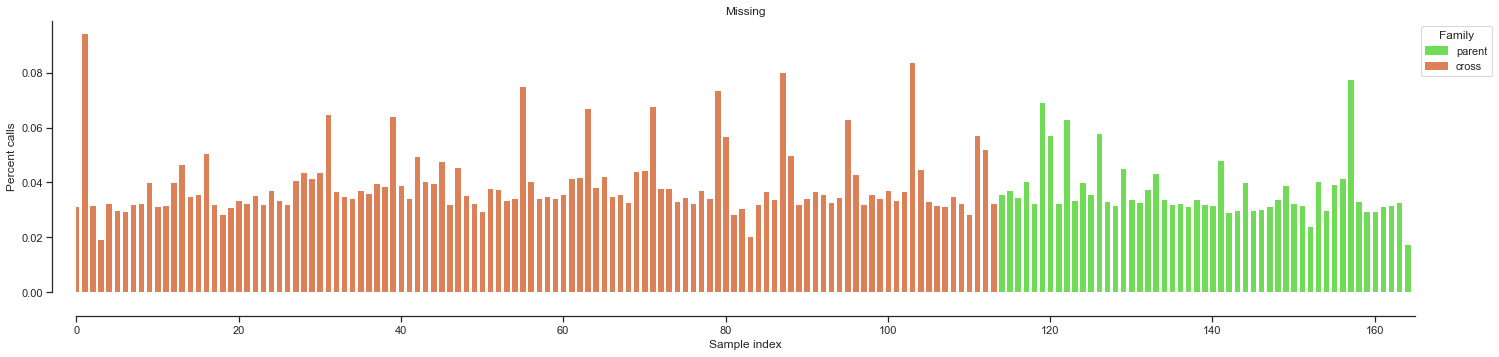

In [36]:
plot_genotype_frequency(pc_missing, 'Missing')

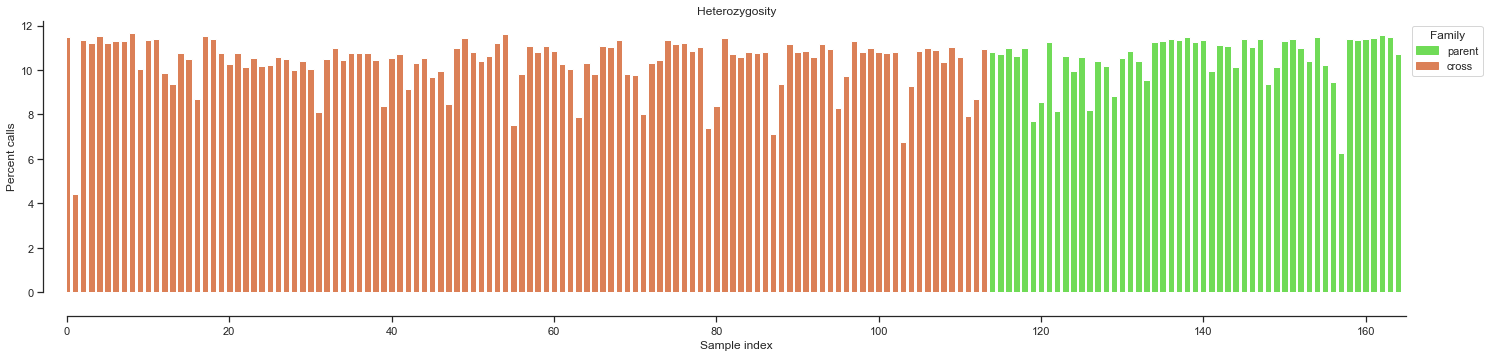

In [37]:
plot_genotype_frequency(pc_het, 'Heterozygosity')

In [38]:
np.argsort(pc_missing)[-1]

1

In [39]:
samples

,ID,fam
0,V51346,cross
1,V51347,cross
2,V51348,cross
3,V51349,cross
4,V51350,cross
...,...,...
160,V5920,parent
161,V5923,parent
162,V5930,parent
163,V5934,parent


In [45]:
families = samples.fam.unique()

In [46]:
families

array(['cross', 'parent'], dtype=object)

In [42]:
ac2 = genotypes_subset_2.count_alleles()
ac2

<AlleleCountsChunkedArray shape=(35595409, 2) dtype=int32 chunks=(139045, 2)
   nbytes=271.6M cbytes=77.0M cratio=3.5
   compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
   values=zarr.core.Array>

In [48]:
palette = sns.color_palette("hls",23)
fam_colours = {        
    'cross': palette[7], 
    'parent': palette[1]}

In [49]:
def plot_pca_coords(coords, model, pc1, pc2, ax, sample_family):
    sns.despine(ax=ax, offset=5)
    x = coords[:, pc1]
    y = coords[:, pc2]
    for fam in families:
        flt = (sample_family == fam)
        ax.plot(x[flt], y[flt], marker='o', linestyle=' ', color=fam_colours[fam], 
                label=fam, markersize=6, mec='k', mew=.5)
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model.explained_variance_ratio_[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model.explained_variance_ratio_[pc2]*100))
    

def fig_pca(coords, model, title, sample_family=None):
    if sample_family is None:
        sample_family = samples.fam.values
    # plot coords for PCs 1 vs 2, 3 vs 4
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 2, 1)
    plot_pca_coords(coords, model, 0, 1, ax, sample_family)
    ax = fig.add_subplot(1, 2, 2)
    plot_pca_coords(coords, model, 2, 3, ax, sample_family)
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
    fig.suptitle(title, y=1.02)
    fig.tight_layout()

In [50]:
flt = (ac2[:, :2].min(axis=1) > 1)
gf = genotypes_subset_2.compress(flt, axis=0)
gn = gf.to_n_alt()
gn

<ChunkedArrayWrapper shape=(31961489, 165) dtype=int8 chunks=(15607, 165)
   nbytes=4.9G cbytes=1.1G cratio=4.4
   compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
   values=zarr.core.Array>

In [51]:
coords1, model1 = allel.pca(gn, n_components=10, scaler='patterson')


In [ ]:
fig_pca(coords1, model1, 'Figure 1. Conventional PCA.')


In [ ]:
weirdos = coords1[:,1]>500
samples[weirdos]
###filter samples base in PC2. Expression gives a list samples above 500

In [ ]:

samples2 = samples[~weirdos]

In [ ]:
samples2


In [ ]:
allT = np.repeat(True, len(genotypes_subset_2))


In [ ]:
genotypes_subset_3 = genotypes_subset_2.subset(allT, ~weirdos)


In [ ]:
genotypes_subset_3


In [ ]:
ac3 = genotypes_subset_3.count_alleles()
ac3

In [ ]:
flt2 = (ac3[:, :2].min(axis=1) > 1)
gf2 = genotypes_subset_3.compress(flt2, axis=0)
gn2 = gf2.to_n_alt()

In [ ]:
coords2, model2 = allel.pca(gn2, n_components=10, scaler='patterson')


In [ ]:
fig_pca(coords2, model2, 'Figure 1. Conventional PCA.')


In [ ]:
weirdos2 = coords2[:,1]>1500
samples2[weirdos2]

In [ ]:
samples3 = samples2[~weirdos2]
samples3

In [ ]:
allT = np.repeat(True, len(genotypes_subset_3))
genotypes_subset_4 = genotypes_subset_3.subset(allT, ~weirdos2)
genotypes_subset_4

In [ ]:
ac4 = genotypes_subset_4.count_alleles()
ac4